
START input: 2022-03-15 09:00:00  --> used: 2022-03-15 09:00:00 (Δt=+0s, idx=3240, P0=7524.264)
END   input: 2022-03-15 21:00:00    --> used: 2022-03-15 21:00:00 (Δt=+0s, idx=7560, P1=7316.420)
Window length: 12.000 hours

START input: 2022-03-15 09:00:00  --> used: 2022-03-15 09:00:00 (Δt=+0s, idx=3240, P0=7494.513)
END   input: 2022-03-15 21:00:00    --> used: 2022-03-15 21:00:00 (Δt=+0s, idx=7560, P1=7349.491)
Window length: 12.000 hours

START input: 2022-06-02 08:00:00  --> used: 2022-06-02 07:54:06 (Δt=-354s, idx=37, P0=4191.687)
END   input: 2022-06-02 20:00:00    --> used: 2022-06-02 20:10:48 (Δt=+648s, idx=48, P1=3966.501)
Window length: 12.278 hours

START input: 2022-06-02 08:00:00  --> used: 2022-06-02 08:07:52 (Δt=+472s, idx=42, P0=4645.782)
END   input: 2022-06-02 20:00:00    --> used: 2022-06-02 20:13:07 (Δt=+787s, idx=52, P1=4606.700)
Window length: 12.088 hours


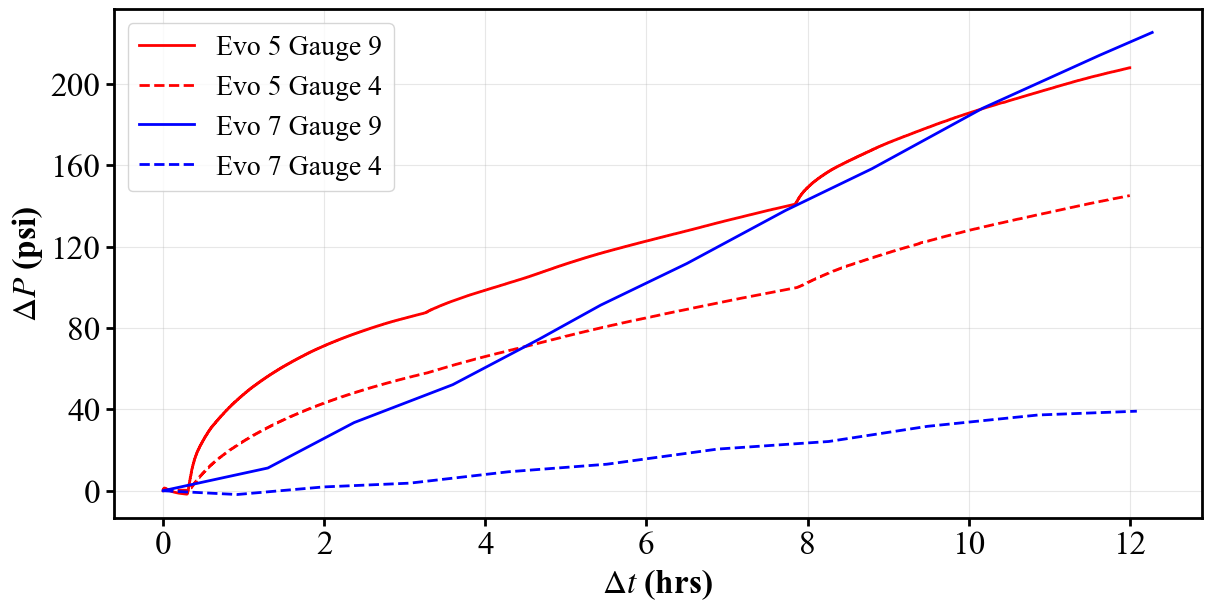

In [24]:
%reload_ext autoreload
%autoreload 2


from plot_style import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 1) 工具函数
# =========================

def _normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns={c: str(c).strip().lower().replace(" ", "") for c in df.columns})

def _align_target_tz(target: pd.Timestamp, series_tz):
    """让 target 的时区和 series 一致（避免 tz-aware vs tz-naive 报错）"""
    if series_tz is None:
        # 数据是 naive，target 若带 tz 则去掉 tz
        return target.tz_convert(None) if target.tzinfo is not None else target
    else:
        # 数据带 tz，target 若 naive 则按该 tz localize
        return target.tz_localize(series_tz) if target.tzinfo is None else target.tz_convert(series_tz)

def read_pressure_excel(
    xls_path: str,
    sheet=0,
    time_col="date",
    pressure_col="pressure",
    unit="s",            # 你的 date 是 epoch 秒就用 's'
    tz=None              # 需要的话填 "America/Chicago"，不需要就 None
):
    df = pd.read_excel(xls_path, sheet_name=sheet, engine="openpyxl")
    df = _normalize_columns(df)

    required = {time_col, pressure_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"{xls_path} 缺少列: {missing}；当前列为: {list(df.columns)}")

    t_raw = df[time_col]
    p = pd.to_numeric(df[pressure_col], errors="coerce")

    # 时间列：epoch 数值 或 已经是 datetime
    if np.issubdtype(t_raw.dtype, np.number):
        t = pd.to_datetime(t_raw, unit=unit, utc=(tz is not None))
        if tz is not None:
            t = t.dt.tz_convert(tz)
    else:
        t = pd.to_datetime(t_raw, errors="coerce")
        if tz is not None and getattr(t.dt, "tz", None) is None:
            t = t.dt.tz_localize(tz)

    # 只保留到“秒”精度（你要求精确到秒就行）
    t = t.dt.round("s")

    out = pd.DataFrame({"t": t, "p": p}).dropna().sort_values("t").reset_index(drop=True)
    return out


def relative_pressure_in_window(df_tp: pd.DataFrame, start_time, end_time, keep_end=True):
    """
    - start_time / end_time：你输入的时间点（字符串/datetime/Timestamp 都行）
    - 自动找最近采样点作为 start/end
    - dp = p - p(start)
    - hours = (t - t(start)) / 3600
    """
    if df_tp.empty:
        raise ValueError("df_tp 为空")

    series_tz = getattr(df_tp["t"].dt, "tz", None)

    start_in = pd.to_datetime(start_time).round("s")
    end_in   = pd.to_datetime(end_time).round("s")

    start_in = _align_target_tz(start_in, series_tz)
    end_in   = _align_target_tz(end_in, series_tz)

    i0 = int((df_tp["t"] - start_in).abs().idxmin())
    i1 = int((df_tp["t"] - end_in).abs().idxmin())
    if i1 < i0:
        i0, i1 = i1, i0
        start_in, end_in = end_in, start_in  # 让输入也跟着区间方向一致（方便理解）

    t0 = df_tp.loc[i0, "t"]
    p0 = df_tp.loc[i0, "p"]
    t1 = df_tp.loc[i1, "t"]
    p1 = df_tp.loc[i1, "p"]

    dfw = df_tp.iloc[i0:(i1 + 1 if keep_end else i1)].copy()
    dfw["hours_since_start"] = (dfw["t"] - t0).dt.total_seconds() / 3600.0
    dfw["dp"] = dfw["p"] - p0

    meta = {
        "t_start_input": start_in, "t_end_input": end_in,
        "t_start_used": t0, "t_end_used": t1,
        "p_start_used": p0, "p_end_used": p1,
        "dt_start_sec": (t0 - start_in).total_seconds(),
        "dt_end_sec": (t1 - end_in).total_seconds(),
        "i_start": i0, "i_end": i1,
    }
    return dfw, meta



# =========================
# 2) 你只需要改这里：每条曲线一个 config（可无限加）
# =========================
configs = [
    {
        "path": r"C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 5 (POP)/13004.xlsx",
        "sheet": 0,
        "unit": "s",
        "label": "Evo 5 Gauge 9",
        "start_time": "2022-03-15 09:00:00",
        "end_time":   "2022-03-15 21:00:00",
        "style": {"color": "red", "linestyle": "-",  "linewidth": 2},
    },
    {
        "path": r"C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 5 (POP)/15321.xlsx",
        "sheet": 0,
        "unit": "s",
        "label": "Evo 5 Gauge 4",
        "start_time": "2022-03-15 09:00:00",
        "end_time":   "2022-03-15 21:00:00",
        "style": {"color": "red", "linestyle": "--",  "linewidth": 2},
    },

    {
        "path": r"C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/13004.xlsx",
        "sheet": 0,
        "unit": "s",
        "label": "Evo 7 Gauge 9",
        "start_time": "2022-06-02 08:00:00",
        "end_time":   "2022-06-02 20:00:00",
        "style": {"color": "#0000FF", "linestyle": "-",  "linewidth": 2},
    },

    {
        "path": r"C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/15321.xlsx",
        "sheet": 0,
        "unit": "s",
        "label": "Evo 7 Gauge 4",
        "start_time": "2022-06-02 08:00:00",
        "end_time":   "2022-06-02 20:00:00",
        "style": {"color": "#0000FF", "linestyle": "--",  "linewidth": 2},
    },
]

# =========================
# 3) 批量计算 + 叠图
# =========================
fig, ax = make_standard_figure(figsize=(12, 6), )#color_cycle = ("red","red","blue","blue")

for cfg in configs:
    df_tp = read_pressure_excel(
        cfg["path"],
        sheet=cfg.get("sheet", 0),
        unit=cfg.get("unit", "s"),
        tz=cfg.get("tz", None),   # 需要时区就填 "America/Chicago"
    )

    df_rel, meta = relative_pressure_in_window(df_tp, cfg["start_time"], cfg["end_time"])

    # ===== 打印匹配到的时间点信息 =====
    print("\n" + "="*80)
    # print(f'File: {cfg["path"]}')
    # print(f'Label: {cfg.get("label","")}')
    print(f'START input: {meta["t_start_input"]}  --> used: {meta["t_start_used"]} '
          f'(Δt={meta["dt_start_sec"]:+.0f}s, idx={meta["i_start"]}, P0={meta["p_start_used"]:.3f})')
    print(f'END   input: {meta["t_end_input"]}    --> used: {meta["t_end_used"]} '
          f'(Δt={meta["dt_end_sec"]:+.0f}s, idx={meta["i_end"]}, P1={meta["p_end_used"]:.3f})')
    print(f'Window length: {(meta["t_end_used"] - meta["t_start_used"]).total_seconds()/3600.0:.3f} hours')
    print("="*80)

    label = (
        f'{cfg.get("label","")}'
        # f'start_used={pd.to_datetime(meta["t_start_used"]).strftime("%Y-%m-%d %H:%M:%S")}, '
        # f'end_used={pd.to_datetime(meta["t_end_used"]).strftime("%Y-%m-%d %H:%M:%S")}'
    )

    style = cfg.get("style", {})  # 没写就默认 Matplotlib 循环色
    line, = ax.plot(df_rel["hours_since_start"],
                    -1*df_rel["dp"],
                    label=cfg.get("label",""),
                      **style)
    # ax.plot(df_rel["hours_since_start"], df_rel["dp"]*-1, lw=1.8, label=label)

ax.set_xlabel(r"$\Delta t$ (hrs)")
ax.set_ylabel(r"$\Delta P$ (psi)")
ax.grid(True, alpha=0.3)
ax.legend(loc="best")
# plt.tight_layout()
plt.show()
